# **Kickstarter**


# Project Brief

The aim of the project is to use the Kickstarter dataset to discover if there is a model for predicting the success or failure of any given kickstarter. 

# EDA: Basic Data Exploration

Explore the data and see if there are any interesting findings through EDA 

In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Group Project - Kickstarter/projectdata.csv')

In [6]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Top 10 Most Pledged Projects

In [7]:
df.sort_values(by='pledged', ascending=False)[:10]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
157270,1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:42,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.00
250254,342886736,COOLEST COOLER: 21st Century Cooler that's Act...,Product Design,Design,USD,2014-08-30,50000.0,2014-07-08 10:14:37,13285226.36,successful,62642,US,13285226.36,13285226.36,50000.00
216629,2103598555,"Pebble 2, Time 2 + All-New Pebble Core",Product Design,Design,USD,2016-06-30,1000000.0,2016-05-24 15:49:52,12779843.49,successful,66673,US,12779843.49,12779843.49,1000000.00
289915,545070200,Kingdom Death: Monster 1.5,Tabletop Games,Games,USD,2017-01-08,100000.0,2016-11-25 06:01:41,12393139.69,successful,19264,US,5228482.00,12393139.69,100000.00
282416,506924864,Pebble: E-Paper Watch for iPhone and Android,Product Design,Design,USD,2012-05-19,100000.0,2012-04-11 06:59:04,10266845.74,successful,68929,US,10266845.74,10266845.74,100000.00
218147,2111201788,Expect the Unexpected. digiFilm™ Camera by YAS...,Product Design,Design,HKD,2017-11-19,800000.0,2017-10-10 12:52:25,10035296.00,successful,6935,HK,4788.64,1285142.98,102449.83
293861,565687737,The World's Best TRAVEL JACKET with 15 Feature...,Product Design,Design,USD,2015-09-03,20000.0,2015-07-07 13:52:34,9192055.66,successful,44949,US,9192055.66,9192055.66,20000.00
187652,1955357092,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20,10000.0,2015-01-20 19:00:19,8782571.99,successful,219382,US,8782571.99,8782571.99,10000.00
6665,1033978702,OUYA: A New Kind of Video Game Console,Gaming Hardware,Games,USD,2012-08-09,950000.0,2012-07-10 14:44:41,8596474.58,successful,63416,US,8596474.58,8596474.58,950000.00
309630,647013276,"THE 7th CONTINENT – What Goes Up, Must Come Down.",Tabletop Games,Games,USD,2017-10-19,40000.0,2017-09-26 20:00:02,7072757.00,successful,43733,US,1574139.50,7072757.00,40000.00


Shape and Missing Values

In [8]:
df.shape

(378661, 15)

In [9]:
df.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

## Handling Unwanted & Missing Data

'State' is the identified target variable. From a basic value counts of the column, we can see that it is currently not a binary column (success/failure).

We will remove the undefined values because it is difficult to determine what that means (could be either success or failure). 'Live' values will also be removed since they indiciate ongoing projects and we cannot evaluate their success yet. 

Values that fall under 'canceled' or 'suspended' will be considered as 'failed' as well

In [10]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [11]:
df = df[(df['state'] != 'undefined') & (df['state'] != 'live')]
df['state'] = df['state'].replace({'canceled': 'failed', 'suspended': 'failed'})

After removing values, we can see successful projects only account for about a third of all projects

In [12]:
df.state.value_counts()

failed        238344
successful    133956
Name: state, dtype: int64

New shape reflects the roughly 6000 rows removed. 
By removing the 'undefined' rows, we have also significantly reduced the number of missing values in 'usd pledged'. However, we will also be removing 'usd pledged' and 'usd pledged_real' since these are directly related to how Kickstarter determines if a project is successful (Pledged amount >= Goal)

In [13]:
df.shape

(372300, 15)

In [14]:
df.isnull().sum()

ID                    0
name                  4
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         234
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [15]:
df.drop(columns=['ID','usd pledged', 'usd_pledged_real'], inplace=True)

To unify the currency of all the goals, it would be reasonable to use 'usd_goal_real' instead of 'goal'.  For the following EDA, goal will be kept temporarily in case there is use for it.

### Finding Anomalies in the Data

A for loop to run through each column to help identify any types of values in the data that are warped or in a different format than other values in same column

In [16]:
for column in list(df.columns):
  print()
  print(df[column].value_counts())
  print()


New EP/Music Development                                15
Canceled (Canceled)                                     13
N/A (Canceled)                                          11
Music Video                                             11
Cancelled (Canceled)                                    10
                                                        ..
Brain - Short Film                                       1
Speaking for Those Who Can't - The Bullycide Project     1
Lets hack the law.                                       1
Berkowski's Eclipse                                      1
First Edition Hardcover of "The Wheel Diver"             1
Name: name, Length: 369531, dtype: int64


Product Design     22075
Documentary        16081
Tabletop Games     14072
Music              13414
Shorts             12311
                   ...  
Residencies           69
Letterpress           48
Chiptune              35
Literary Spaces       23
Taxidermy             13
Name: category, Length: 159, dty

### Identifying where countrys are **N,0"**

After looking through the value counts above, 'N,0"' is found in the country column. As there is no clear way of identifying which country it means (and it would be a leap of logic to assume it is the same as 'NO'), we will reclassify it as 'Unknown'.

In [17]:
df[df['country'] == 'N,0"']

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real
2457,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,5000.0,2016-04-26 19:46:26,5170.00,successful,0,"N,0""",5000.00
4338,Help OrphanSporks Record Our Fourth Album!,Music,Music,USD,2016-05-14,2500.0,2016-04-11 07:20:59,1375.00,failed,0,"N,0""",2500.00
4892,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,5000.0,2016-04-11 19:29:17,5296.00,successful,0,"N,0""",5000.00
5353,Help Parker Brown make his first solo album,Music,Music,USD,2016-05-21,3800.0,2016-04-21 16:14:28,5077.00,successful,0,"N,0""",3800.00
5597,Help BETHANY record a NEW single in Nash!,Music,Music,USD,2016-05-08,3500.0,2016-04-04 23:32:00,3502.13,successful,0,"N,0""",3500.00
...,...,...,...,...,...,...,...,...,...,...,...,...
368889,A Taste of San Diego's Singer Songwriters,Music,Music,USD,2016-05-09,7500.0,2016-04-09 02:21:45,1408.00,failed,0,"N,0""",7500.00
371387,Spoken Fruit Magazine,Print,Journalism,EUR,2016-04-28,15000.0,2016-03-29 16:02:57,1933.00,failed,0,"N,0""",17104.54
372375,Help Danelle Finish Her First EP Album,Music,Music,USD,2016-04-28,3500.0,2016-04-05 18:56:21,3686.00,successful,0,"N,0""",3500.00
375359,Faith,Film & Video,Film & Video,USD,2016-05-06,9000.0,2016-03-07 04:17:33,2.00,failed,0,"N,0""",9000.00


In [18]:
df['country'] = df['country'].replace({'N,0"': 'Unknown'})

### Convert to DateTime

In the initial exploration, it was found that both 'deadline' and 'launched' were not in datetime format. Quick code to convert them to Y/M/D format.

**NOTE**: Consider retaining the hour as a separate column - may be worth exploring

In [19]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched']).dt.date)

In [20]:
df.dtypes

name                     object
category                 object
main_category            object
currency                 object
deadline         datetime64[ns]
goal                    float64
launched         datetime64[ns]
pledged                 float64
state                    object
backers                   int64
country                  object
usd_goal_real           float64
dtype: object

### Convert 'State' to Binary Format

For the modeling section later on, it could be useful to have the success/failure as a binary number rather than as a string. We will create a new column to reflect that. 

However for the EDA, it will be easier to visualise 'Successful' and 'Failure', so we will drop the 'state' column later on.

In [21]:
df['target'] = [1 if i == 'successful' else 0 for i in df.state]

In [22]:
df['target'].value_counts()

0    238344
1    133956
Name: target, dtype: int64

## **BACKERS:** Analysing Backers

It could be interesting to look at the relationship between the number of backers and the success of a project. However it is important to note that the backers are part of the result and will skew any prediction model later on. We will be looking at the backers to confirm our intuition that higher number of backers will lead to a greater chance of Kickstarter success, but we will not be using it as part of our model.

In [23]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0


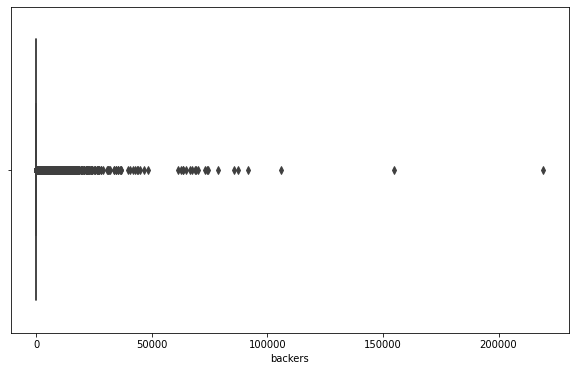

In [24]:
plt.subplots(figsize=(10,6))
sns.boxplot(data=df, x='backers')

The distribution of values in backers is heavily influenced by outliers and it will be difficult to perform EDA in any meaningful way if the graphs are as above.  Therefore, we perform a log calculation to the column to allow for better visualisation on a logarithmic scale.

### Create column for log backers

In [25]:
df['log_backers'] = [0 if i == 0 else np.log10(i) for i in df.backers]

In [26]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128


### Replotting Boxplot

We can see a much clearer distribution after creating the log scale. Most values are observed to be between 0-100 (10^0 - 10^2). 

Median is 12

[Text(0, 0, '1'),
 Text(0, 0, '10'),
 Text(0, 0, '100'),
 Text(0, 0, '1000'),
 Text(0, 0, '10000'),
 Text(0, 0, '100000')]

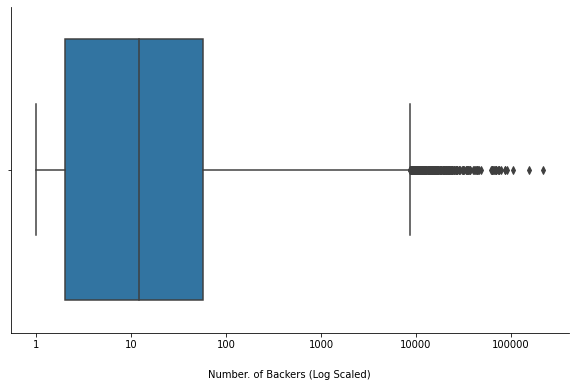

In [27]:
plt.subplots(figsize=(10,6))
p1 = sns.boxplot(data=df, x='log_backers')
sns.despine(left=False, bottom=False, right=True)
plt.xlabel('Number. of Backers (Log Scaled)', labelpad=20)
p1.set_xticks(range(6))
p1.set_xticklabels(['1', '10', '100', '1000', '10000', '100000'])

In [28]:
df.backers.median()

12.0

### Visualising Relationship between success and number of backers

As indicated by the boxplot and confirmed by the value counts; around 75-80% of the data falls within 100 backers

In [29]:
df.backers.value_counts()[:100].sum()

312180

In [30]:
df_small_backers = df[df['backers'] <= 100]

From the graph below, we can see that having between 20-30 backers is roughly the target threshold Kickstarters will want to start having around a 50% chance of being successful in meeting their goal.  

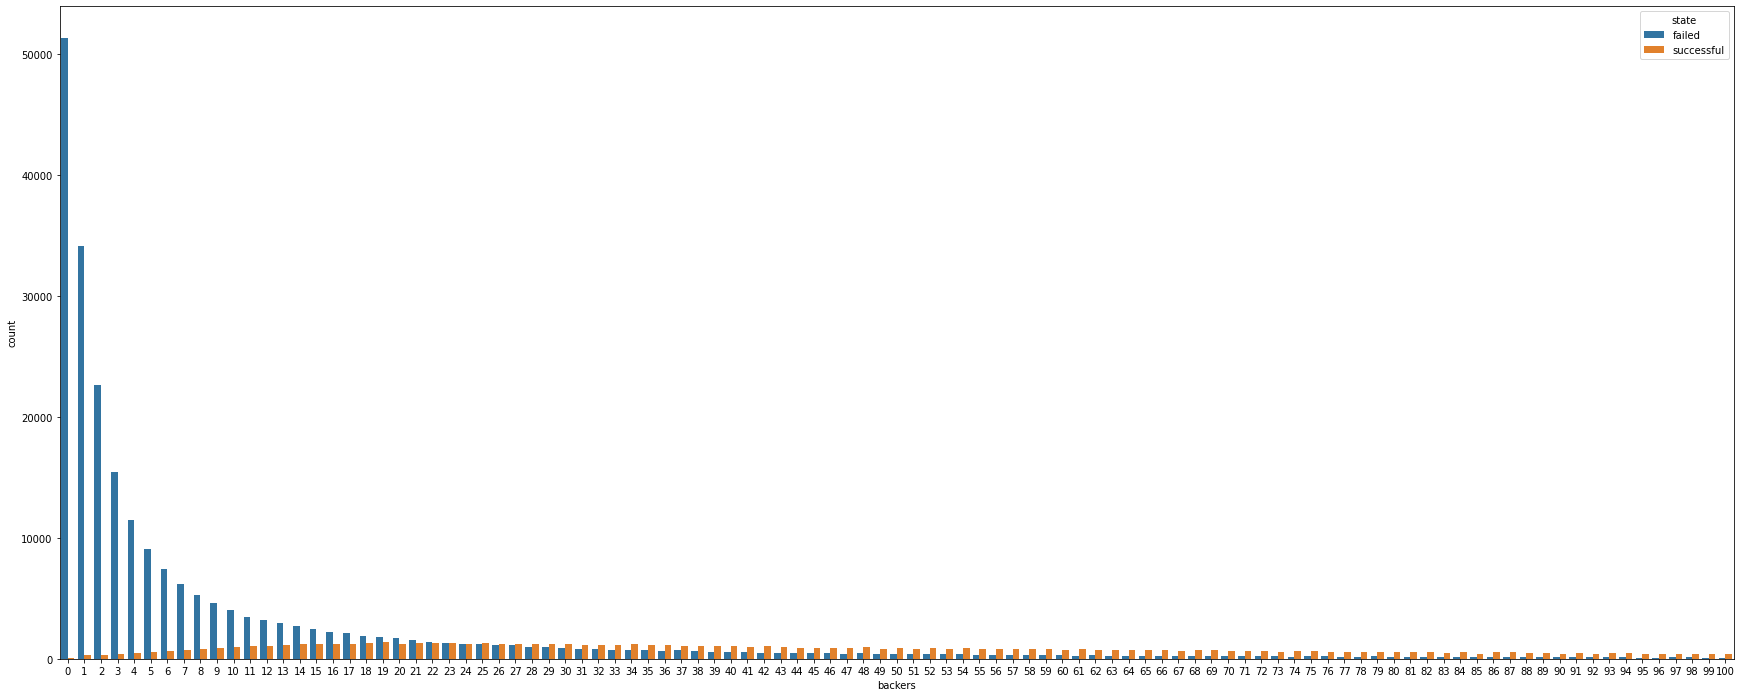

In [31]:
plt.subplots(figsize=(30,12))
sns.countplot(data=df_small_backers, x='backers', hue='state')

Taking a selection of larger numbers of backers, we can see a similar trend. As the number of backers increases, the relative success rate nominally increases as well.

In [32]:
df_small_backers = df[(df['backers'] <= 1000) & (df['backers'] >= 500)]

In [33]:
df_small_backers.state.value_counts()

successful    6058
failed         477
Name: state, dtype: int64

This is further confirmed when looking at the log backers column. The successful Kickstarters seem normally distributed when logged, but it is still clear that projects with few backers are much more likely to fail.

(0.0, 5.0)

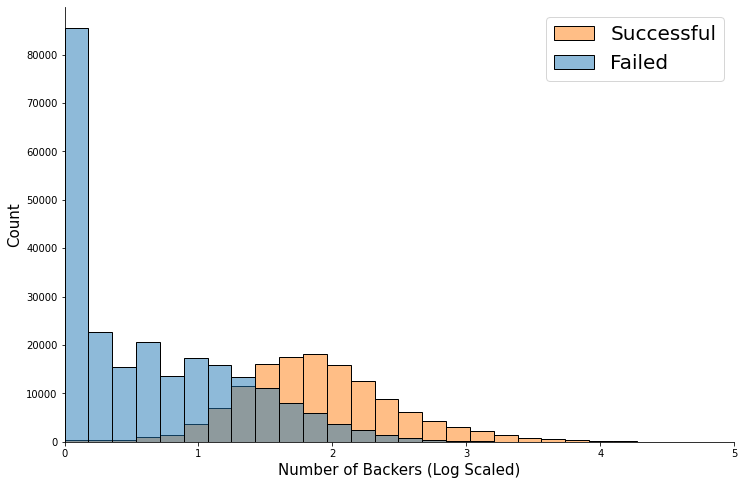

In [34]:
plt.subplots(figsize=(12,8))
colors = ["#97AABD","#C96567"]
sns.histplot(data=df, x='log_backers', bins=30, hue='state')
sns.despine(left=False, bottom=False, right=True)
plt.xticks(fontsize=10)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Number of Backers (Log Scaled)', fontsize=15)
plt.legend(labels=['Successful', 'Failed'],loc='upper right', prop={'size': 20})
plt.xlim(0, 5)


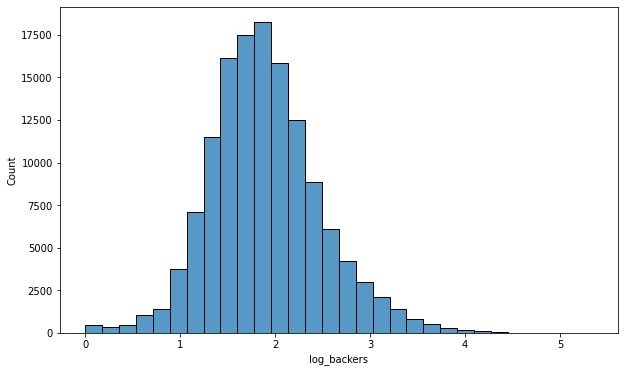

In [35]:
plt.subplots(figsize=(10,6))
sns.histplot(data=df[df.state == 'successful'], x='log_backers', bins=30)

This KDE plot shows the same conclusion in a similar way, although not very clearly. If you have few backers, you are highly likely to fail. There are much fewer cases of having a high number of backers, but the chance of success is higher which is why it is easier to see a more solid orange line further to the right.

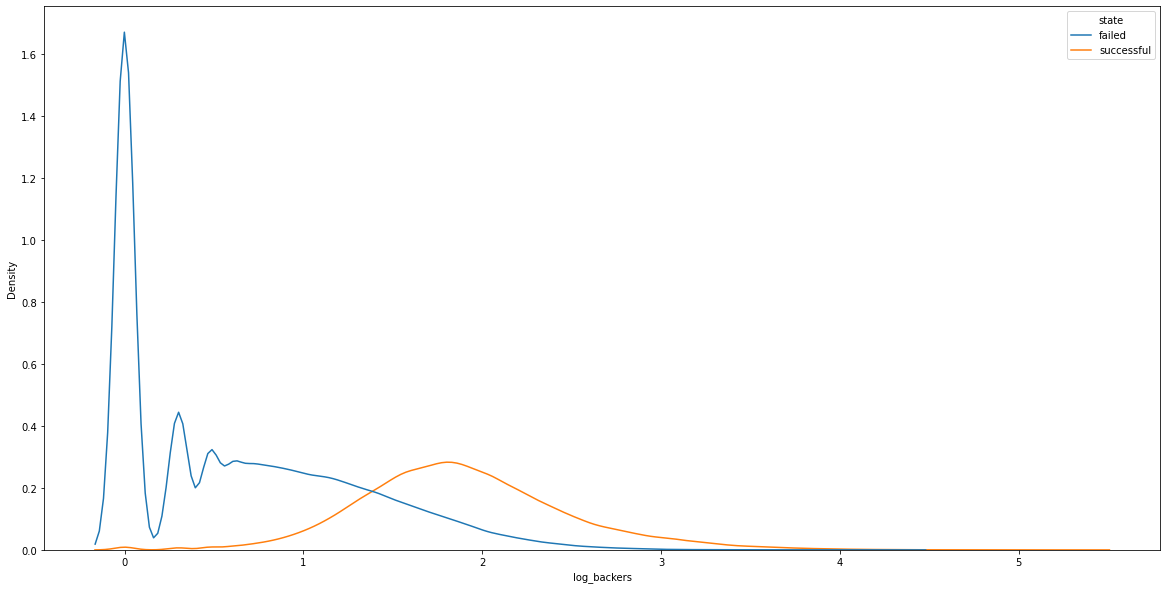

In [36]:
plt.subplots(figsize=(20,10))
sns.kdeplot(data=df, x='log_backers', hue='state')

### Quick Look - Backers vs. Pledge Amount

A very brief look to see if there is any sort of linear relationship between number of backers and the amount pledged. The graphs generally confirm this relationship, and it is interesting to note that Games, Design, and Technology seem to do the best. On the flip side, Film and Video seem to fail often.

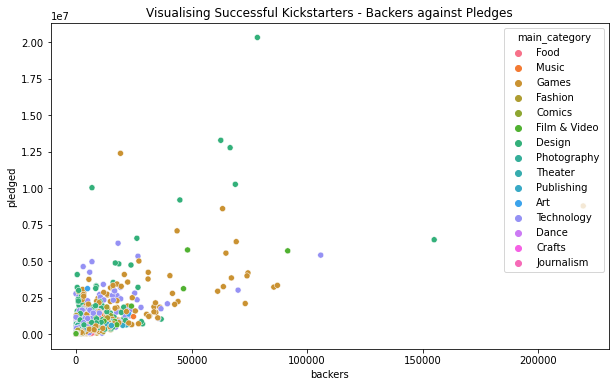

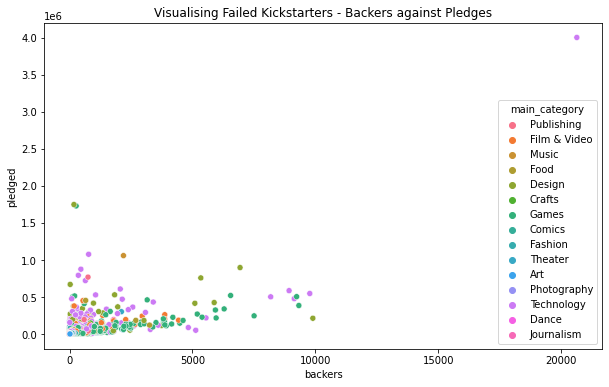

In [37]:
plt.subplots(figsize=(10,6))
sns.scatterplot(data=df[df.state == 'successful'], x='backers', y='pledged', hue='main_category')
plt.title('Visualising Successful Kickstarters - Backers against Pledges')
plt.show()

plt.subplots(figsize=(10,6))
sns.scatterplot(data=df[df.state == 'failed'], x='backers', y='pledged', hue='main_category')
plt.title('Visualising Failed Kickstarters - Backers against Pledges')
plt.show()

### Random Extras

Total Pledged Amount 

In [38]:
df.pledged.sum()

3633016851.24

Interesting finding just to see what the crazy outliers in terms of backing are. 

In [39]:
df[df.backers >= 100000]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers
75900,Fidget Cube: A Vinyl Desk Toy,Product Design,Design,USD,2016-10-20,15000.0,2016-08-30,6465690.30,successful,154926,US,15000.0,1,5.190124
187652,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20,10000.0,2015-01-20,8782571.99,successful,219382,US,10000.0,1,5.341201
292244,"Bring Reading Rainbow Back for Every Child, Ev...",Web,Technology,USD,2014-07-02,1000000.0,2014-05-28,5408916.95,successful,105857,US,1000000.0,1,5.024720


## **CATEGORIES:** Exploring Categories in Kickstarter Projects

### General Overview

We want to explore which categories of Kickstarters are more likely to succeed. The following graphs attempt to visualise this.

As seen before, roughly 2/3 of all projects fail, and 1/3 succeed. 

Film stands out as a big category that is likely to fail.

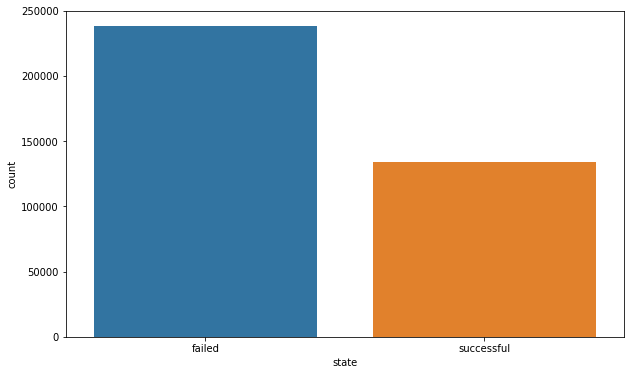

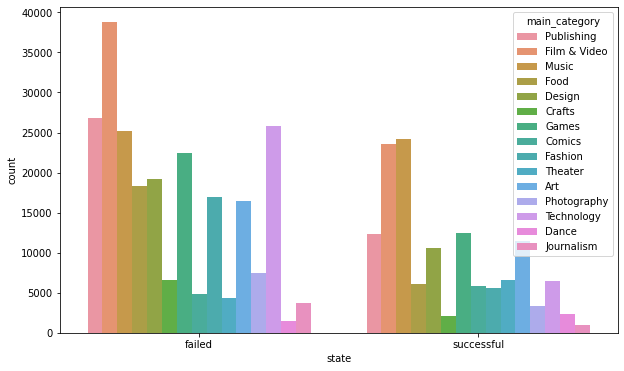

In [40]:
plt.subplots(figsize=(10,6))
sns.countplot(data=df, x='state')
plt.show()
plt.subplots(figsize=(10,6))
sns.countplot(data=df, x='state', hue='main_category')
plt.show()
# plt.subplots(figsize=(10,6))
# sns.countplot(data=df, x='state', hue='category')

Top 10 Categories that appear the most among all Kickstarter projects

                category
Product Design     22075
Documentary        16081
Tabletop Games     14072
Music              13414
Shorts             12311
Video Games        11744
Food               11454
Film & Video        9203
Fiction             9119
Fashion             8514


Text(0.5, 1.0, 'Top 10 Most Frequent Categories')

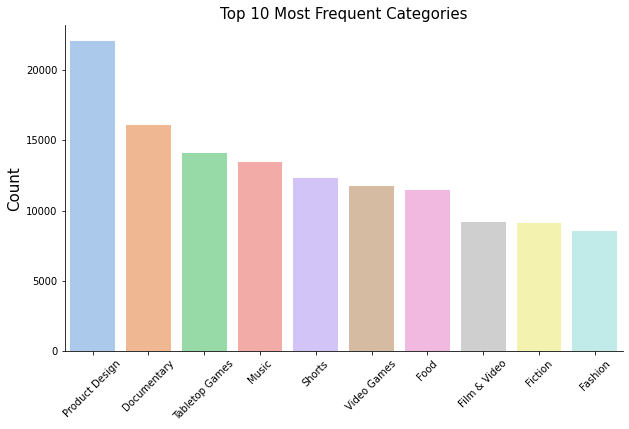

In [41]:
top10_cat = pd.DataFrame(df.category.value_counts()[:10])
print(top10_cat)
plt.show()
plt.subplots(figsize=(10,6))
sns.barplot(x=top10_cat.index, y=top10_cat['category'], palette='pastel')
sns.despine(left=False, bottom=False, right=True)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=45)
plt.title('Top 10 Most Frequent Categories', fontsize=15)

### Top 10 Successful/Failed Categories by Frequency

A quick view of which categories show up the most as failed or successful.

In [42]:
df_cat = df.groupby('category')['state'].value_counts().unstack('state')

Text(0.5, 1.0, 'Top 10 Failed Categories by Frequency')

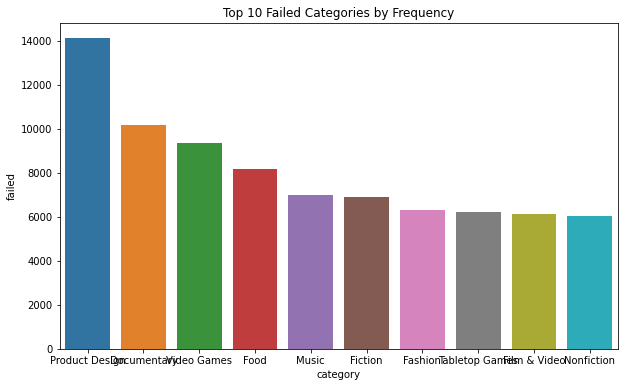

In [43]:
plt.subplots(figsize=(10,6))
top_fail = pd.DataFrame(df_cat['failed'].sort_values(ascending=False)[:10])
sns.barplot(data=top_fail,x=top_fail.index, y='failed')
plt.title('Top 10 Failed Categories by Frequency')
#top_fail

Text(0.5, 1.0, 'Top 10 Successful Categories by Frequency')

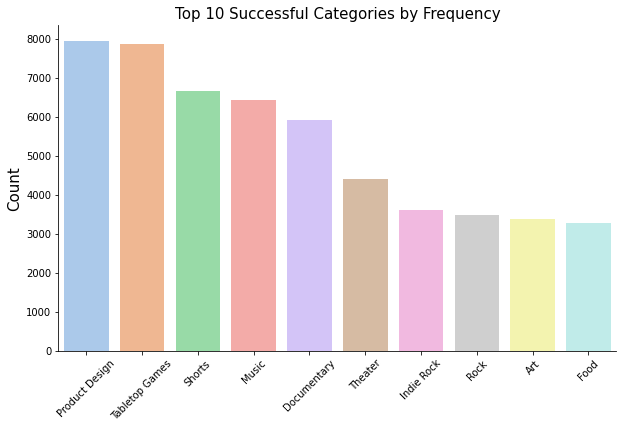

In [44]:
plt.subplots(figsize=(10,6))
top_success = pd.DataFrame(df_cat['successful'].sort_values(ascending=False)[:10])
sns.barplot(data=top_success,x=top_success.index, y='successful',palette='pastel')
sns.despine(left=False, bottom=False, right=True)
plt.ylabel('Count', fontsize=15)
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Top 10 Successful Categories by Frequency', fontsize=15)

Looking only at the frequency may not accurately capture which categories are more likely to be successful. Having a large volume of a category does not necessarily mean that that category is more easily funded on Kickstarter.

### Top 10 Successful/Failed Categories by Percentage

We take a look at the top 10 categories by percentage of their success and failure to see which types are most/least likely to succeed.

In [45]:
df_cat['s_percentage'] = df_cat.successful / (df_cat.successful + df_cat.failed) * 100
df_cat['f_percentage'] = df_cat.failed / (df_cat.successful + df_cat.failed) * 100
df_cat.head()

state,failed,successful,s_percentage,f_percentage
category,,,,
3D Printing,432,242,35.905045,64.094955
Academic,717,188,20.773481,79.226519
Accessories,2036,1073,34.512705,65.487295
Action,626,107,14.597544,85.402456
Animals,189,63,25.000000,75.000000


Text(0.5, 1.0, 'Top 10 Successful Categories by Percentage')

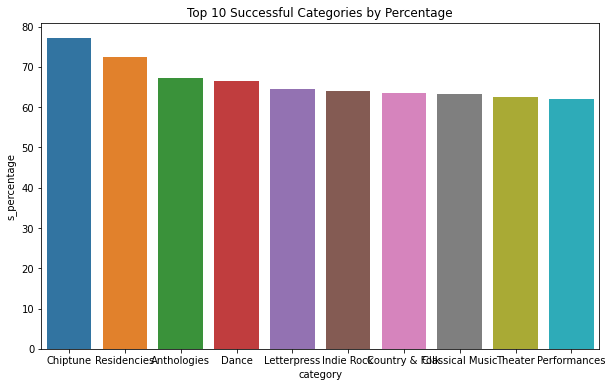

In [46]:
plt.subplots(figsize=(10,6))
top_success_p = pd.DataFrame(df_cat['s_percentage'].sort_values(ascending=False)[:10])
sns.barplot(data=top_success_p,x=top_success_p.index, y='s_percentage')
plt.title('Top 10 Successful Categories by Percentage')

Text(0.5, 1.0, 'Top 10 Failed Categories by Percentage')

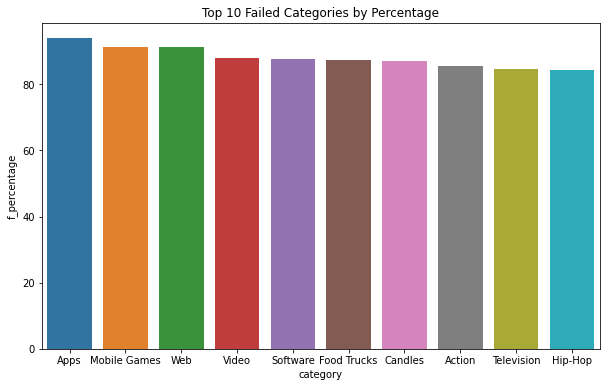

In [47]:
plt.subplots(figsize=(10,6))
top_fail_p = pd.DataFrame(df_cat['f_percentage'].sort_values(ascending=False)[:10])
sns.barplot(data=top_fail_p,x=top_fail_p.index, y='f_percentage')
plt.title('Top 10 Failed Categories by Percentage')

Residencies shows up as a relatively more 'successful' category. But a closer look finds this category to be largely random.

In [48]:
df[df.category == 'Residencies']

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers
22912,"Residencia en Guanajuato para ensayo de ""La Ca...",Residencies,Dance,MXN,2017-10-12,10000.0,2017-09-12,650.00,failed,4,MX,527.51,0,0.602060
37001,Cascade Youth Dance: Commonwealth,Residencies,Dance,GBP,2014-06-30,1000.0,2014-05-26,1170.00,successful,9,GB,1714.35,1,0.954243
39991,Plastic Identities,Residencies,Dance,USD,2017-07-20,6500.0,2017-06-20,7106.99,successful,85,US,6500.00,1,1.929419
49862,Peter & Co. SF Presents at The Garage,Residencies,Dance,USD,2014-08-02,4500.0,2014-07-03,805.00,failed,24,US,4500.00,0,1.380211
63571,Turn my house into a ball pit party.,Residencies,Dance,CAD,2014-11-27,1000.0,2014-10-28,1.00,failed,1,CA,877.42,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366208,The Friendship Club,Residencies,Dance,USD,2014-09-03,3000.0,2014-08-04,3545.00,successful,31,US,3000.00,1,1.491362
368667,rLand,Residencies,Dance,CAD,2014-10-18,500000.0,2014-08-19,51.00,failed,6,CA,446030.33,0,0.778151
369507,Lxs Desaparecidxs,Residencies,Dance,USD,2017-08-11,3000.0,2017-07-11,3010.00,successful,75,US,3000.00,1,1.875061
373631,GRADUADOS DANZA 2017,Residencies,Dance,MXN,2017-07-07,370000.0,2017-06-12,2425.00,failed,10,MX,20349.80,0,1.000000


## **GOAL:** A closer look at goal amount vs. success

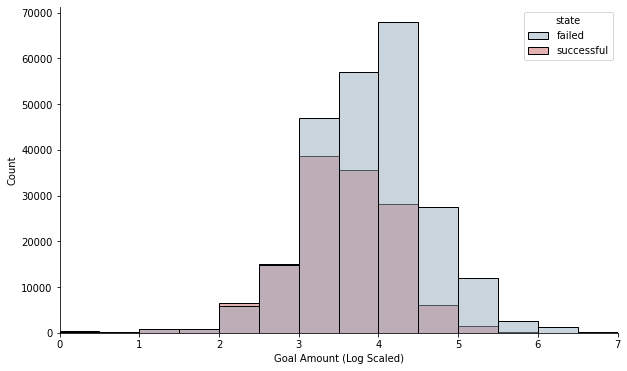

In [49]:
colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))
plt.subplots(figsize=(10,6))
sns.histplot(data=df, x=np.log10(df['goal']), bins=20, hue='state')
sns.despine(left=False, bottom=False, right=True)
plt.xlabel('Goal Amount (Log Scaled)')
plt.xlim(0, 7)
plt.show()
# plt.subplots(figsize=(10,6))
# sns.kdeplot(data=df, x=np.log10(df['goal']), hue='state',fill=True)

A brief look at the effect of how the goal amount may relate to success or failure. The higher the goal amount set, the less likely a project is to be succesfully funded. This is a reasonable take as it should be harder to reach larger numbers.

Below is a look with the converted USD Goal Real which provides a more accurate number since all values are converted to USD. The general shape remains the same.

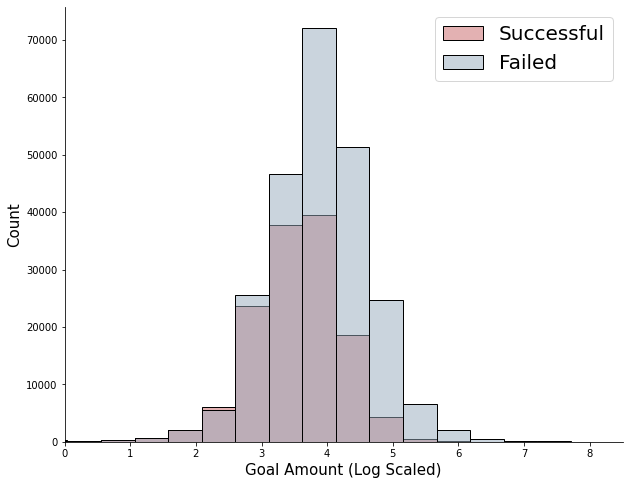

In [50]:
plt.figure(figsize=(10,8))
colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))
sns.histplot(data=df, x=np.log10(df['usd_goal_real']), bins=20, hue='state')
sns.despine(left=False, bottom=False, right=True)
plt.xlabel('Goal Amount (Log Scaled)', fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count', fontsize=15)
plt.legend(labels=['Successful', 'Failed'],loc='upper right', prop={'size': 20})
plt.xlim(0, 8.5)

plt.show()
# plt.subplots(figsize=(10,6))
# sns.kdeplot(data=df, x=np.log10(df['usd_goal_real']), hue='state',fill=True)

## **COUNTRY:** Success Percentage by Country

To explore the effect of the country of origin, we created a separate dataframe to see the success and failure numbers by country.

Since there was a hugely disproportionate number of Kickstarters originating from the US, we decided on using a percentage to better visualise the results.

In [51]:
country_df = df.groupby('country')['state'].value_counts().unstack('state')

In [52]:
country_df.head()

state,failed,successful
country,,
AT,475,107
AU,5759,2010
BE,453,152
CA,10490,4134
CH,560,187


In [53]:
country_df['percentage'] = country_df.successful / (country_df.successful + country_df.failed) * 100
country_df['f_percentage'] = 100 - country_df.percentage
country_df['one'] = 100

The 'one' column is created to help create a better visual on the plot - no other meaning.

In [54]:
sum(country_df.failed) + sum(country_df.successful)

372300

In [55]:
country_df

state,failed,successful,percentage,f_percentage,one
country,,,,,
AT,475,107,18.384880,81.615120,100
AU,5759,2010,25.872056,74.127944,100
BE,453,152,25.123967,74.876033,100
CA,10490,4134,28.268600,71.731400,100
CH,560,187,25.033467,74.966533,100
DE,3159,937,22.875977,77.124023,100
DK,737,360,32.816773,67.183227,100
ES,1732,492,22.122302,77.877698,100
FR,1979,908,31.451334,68.548666,100


Text(0.5, 1.0, 'Percentage of Successful Projects by Country')

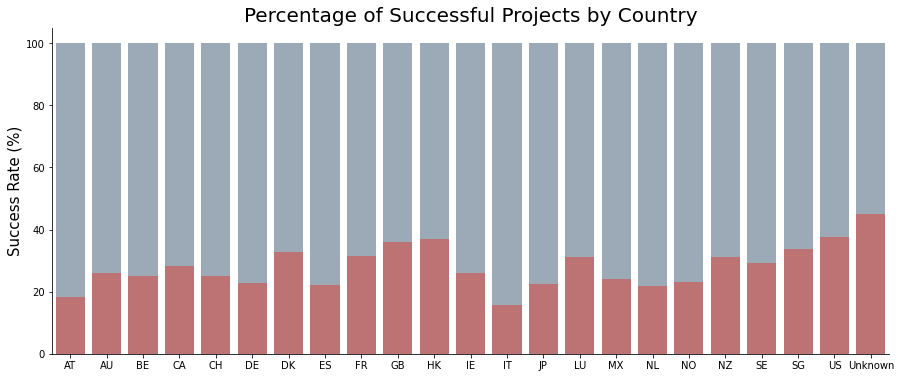

In [56]:
plt.subplots(figsize=(15,6))
sns.barplot(data=country_df, x=country_df.index, y='one', color='#97AABD')
sns.barplot(data=country_df, x=country_df.index, y='percentage', color='#C96567')
sns.despine(left=False, bottom=False, right=True)
plt.ylabel('Success Rate (%)', fontsize=15)
plt.xlabel('', fontsize=15, labelpad=15)
plt.title('Percentage of Successful Projects by Country', fontsize=20)

We can see from the graph that no one country stands out as being exceptional at having successful Kickstarters, although some certainly perform worse than others (ie. IT). An interesting note is that the previously unidentified 'Unknown' category performs the best.

## **CURRENCY:** Success Percentage by Currency

Similar to the country, we will take a look at whether the currency has an effect on the success or failure of any given Kickstarter project.

In [57]:
currency_df = df.groupby('currency')['state'].value_counts().unstack('state')

In [58]:
currency_df.head()

state,failed,successful
currency,,
AUD,5766,2011
CAD,10492,4137
CHF,560,187
DKK,738,362
EUR,13032,3882


In [59]:
currency_df['percentage'] = currency_df.successful / (currency_df.successful + currency_df.failed) * 100
currency_df['f_percentage'] = 100 - currency_df.percentage
currency_df['one'] = 100

The 'one' column is created to help create a better visual on the plot - no other meaning.

In [60]:
sum(currency_df.failed) + sum(currency_df.successful)

372300

In [61]:
currency_df

state,failed,successful,percentage,f_percentage,one
currency,,,,,
AUD,5766,2011,25.858300,74.141700,100
CAD,10492,4137,28.279445,71.720555,100
CHF,560,187,25.033467,74.966533,100
DKK,738,362,32.909091,67.090909,100
EUR,13032,3882,22.951401,77.048599,100
GBP,21336,12081,36.152258,63.847742,100
HKD,367,216,37.049743,62.950257,100
JPY,24,7,22.580645,77.419355,100
MXN,1249,396,24.072948,75.927052,100


Text(0.5, 1.0, 'Percentage of Successful Projects by Currency')

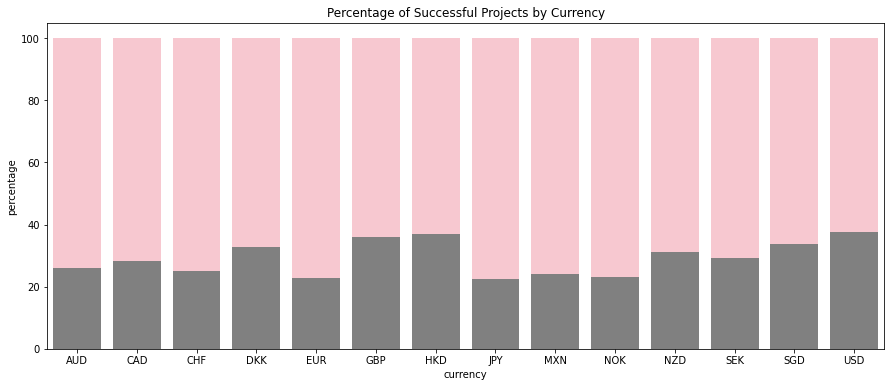

In [62]:
plt.subplots(figsize=(15,6))
sns.barplot(data=currency_df, x=currency_df.index, y='one', color='Pink')
sns.barplot(data=currency_df, x=currency_df.index, y='percentage', color='Grey')
plt.title('Percentage of Successful Projects by Currency')

## **NAME:** Length Matters?

As we are lacking information on the descriptions for the Kickstarter projects in this dataset, we look at the next best thing - the name. We believe there could be a relationship (even if not a strong correlation) between the length of the name (both in characters or words) and the success of a Kickstarter. This is something we may look at including as a feature within our models later.

### Create column for length of title in characters/words

In [63]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128


Four rows have missing names. To avoid errors will fill with 'None'

In [64]:
df[df.name.isna()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers
166851,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01,100.0,failed,1,US,200000.00,0,0.000000
307234,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19,196.0,failed,12,GB,3224.97,0,1.079181
309991,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18,0.0,failed,0,US,2500.00,0,0.000000
338931,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06,220.0,failed,5,US,35000.00,0,0.698970


In [65]:
df.name = df.name.fillna('None')

In [66]:
df['name_words'] = [len(i.split()) for i in df.name]
df['name_chars'] = [len(i) for i in df.name]

In [67]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,7,49
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,8,58


### Visualising Success against Words in Name

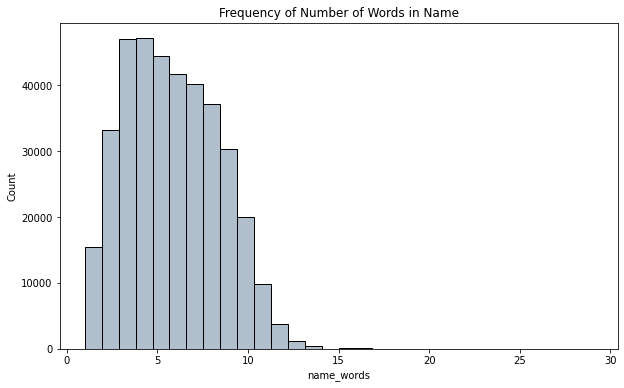

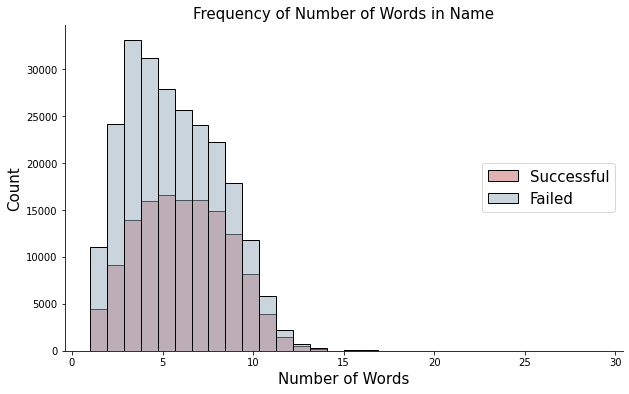

In [68]:
plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='name_words', bins=30)
plt.title('Frequency of Number of Words in Name')
plt.show()

plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='name_words', bins=30, hue='state')
plt.title('Frequency of Number of Words in Name', fontsize=15)
sns.despine(left=False, bottom=False, right=True)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Number of Words', fontsize=15)
plt.legend(labels=['Successful', 'Failed'],loc='center right', prop={'size': 15})
plt.show()

There is no strong indicator that the number of words will correlate to the success rate of a Kickstarter project. 

### Visualising Success against Characters in Name

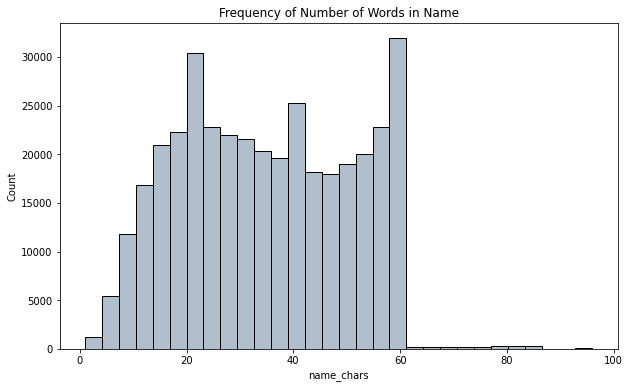

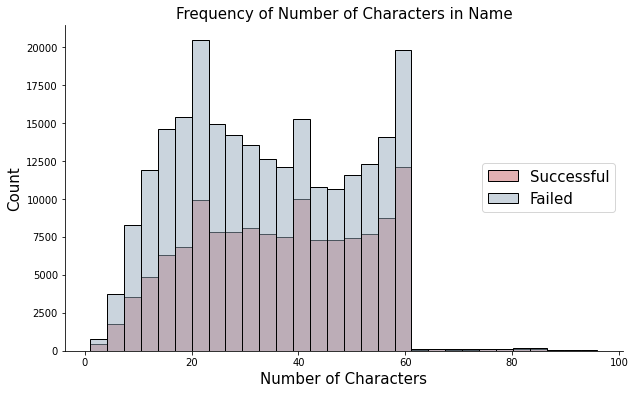

In [69]:
colors = ["#97AABD","#C96567"]
sns.set_palette(sns.color_palette(colors))

plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='name_chars', bins=30)
plt.title('Frequency of Number of Words in Name')
plt.show()

plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='name_chars', bins=30, hue='state')
plt.title('Frequency of Number of Characters in Name', fontsize=15)
sns.despine(left=False, bottom=False, right=True)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Number of Characters', fontsize=15)
plt.legend(labels=['Successful', 'Failed'],loc='center right', prop={'size': 15})
plt.show()

These plots look slightly more interesting as there is a virtual cut off at 60 characters. This could be because Kickstarter created a character limit. 

Reframing seems to show that all the longer character names are from 2010 or prior, which would confirm this.

### Name Character Limit?

In [70]:
df[df.name_chars >= 61]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars
132,"Brandi Emma promotes her new, 5-song EP becaus...",Indie Rock,Music,USD,2010-07-12,10000.0,2010-06-12,4006.0,failed,44,US,10000.0,0,1.643453,14,80
188,Raise funds for the new JonathanGluck and the ...,Rock,Music,USD,2010-09-19,4000.0,2010-07-30,30.0,failed,2,US,4000.0,0,0.301030,11,65
357,Circa Vitae requests crowd fundage to record o...,Indie Rock,Music,USD,2009-11-01,2000.0,2009-08-06,80.0,failed,4,US,2000.0,0,0.602060,13,81
633,Legendary Steamboat Springs Band records an al...,Country & Folk,Music,USD,2010-08-01,5500.0,2010-07-14,1310.0,failed,14,US,5500.0,0,1.146128,10,67
1048,Please Donate Money For My First Music Video S...,Country & Folk,Music,USD,2010-09-17,5000.0,2010-08-18,0.0,failed,0,US,5000.0,0,0.000000,11,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378478,UP COUNTRY | A film about a Maine fishing trip...,Narrative Film,Film & Video,USD,2010-07-17,4000.0,2010-06-08,4289.0,successful,109,US,4000.0,1,2.037426,13,66
378484,"Panacea's New Album ""12 Step Program"" Deserves...",Rock,Music,USD,2010-04-30,3800.0,2010-02-26,5731.0,successful,163,US,3800.0,1,2.212188,14,83
378583,Deep Vein Thrombosis Clot Association - Suppor...,Documentary,Film & Video,USD,2010-10-06,40000.0,2010-07-08,0.0,failed,0,US,40000.0,0,0.000000,9,68
378593,Uncanny Valley - a dudley ghost./miasma record...,Indie Rock,Music,USD,2010-07-05,9000.0,2010-04-07,53.0,failed,2,US,9000.0,0,0.301030,9,69


The following histogram shows that there is almost certainly a character limit being enforced. The few outliers after 2011 may be due to characters being counted differently.

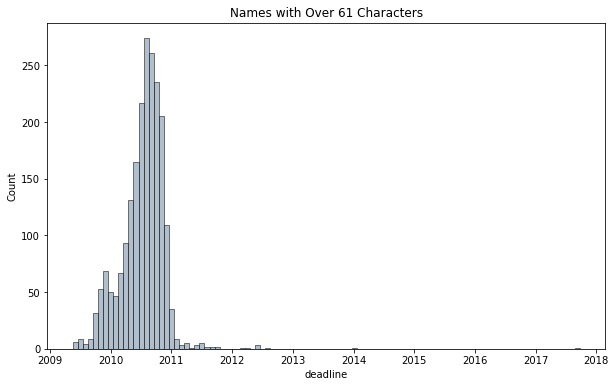

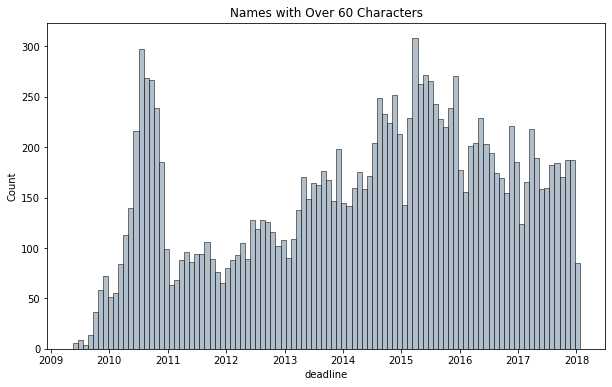

In [71]:
plt.subplots(figsize=(10,6))
sns.histplot(data=df[df.name_chars >= 61], x='deadline', bins=100)
plt.title('Names with Over 61 Characters')
plt.show()

plt.subplots(figsize=(10,6))
sns.histplot(data=df[df.name_chars >= 60], x='deadline', bins=100)
plt.title('Names with Over 60 Characters')
plt.show()

## **DEADLINE/LAUNCHED:** Getting the length of project

In [72]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,7,49
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,8,58


In [73]:
df['project_length'] = (df.deadline - df.launched).dt.days
df['project_length']

0         59
1         60
2         45
3         30
4         56
          ..
378656    30
378657    27
378658    46
378659    31
378660    28
Name: project_length, Length: 372300, dtype: int64

We are getting some outliers with project lengths over 16000 days. These are definitely data errors and we will be converting them to the max project length of 92 days.

In [74]:
df[df['project_length'] >= 93]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars,project_length
2842,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01,0.0,failed,0,US,5000.00,0,0.0,9,46,14867
48147,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01,0.0,failed,0,US,15000.00,0,0.0,8,57,14835
75397,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01,0.0,failed,0,US,700.00,0,0.0,2,19,14750
94579,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01,0.0,failed,0,US,4000.00,0,0.0,9,80,14761
247913,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01,0.0,failed,0,US,10000.00,0,0.0,16,82,14733
273779,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01,0.0,failed,0,US,500.00,0,0.0,4,46,14709
319002,Student Auditions Music 2015,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01,0.0,failed,0,CH,1905.97,0,0.0,4,28,16739


In [75]:
df['project_length'] = df['project_length'].mask(df['project_length'] > 93, 92)

In [76]:
df.project_length.describe()

count    372300.000000
mean         34.175055
std          12.795045
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: project_length, dtype: float64

## **OTHERS**

### Heatmap of Numerical Cats

Heatmap that confirms strong relationship between pledged amount and backers. Nothing out of the ordinary here.

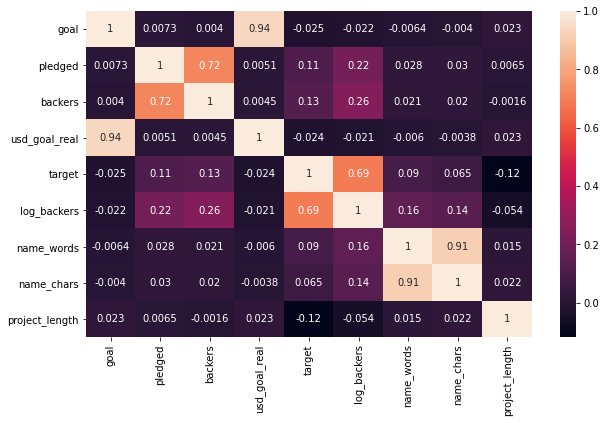

In [77]:
plt.subplots(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)

### Testing Relationship between Pledged/Goal & Success

Further look to confirm the way a 'successful' state is found. In 99% of the cases, as long as the pledged amount exceeds the goal, it is successful.

In [78]:
df2 = df[(df.pledged >= df.goal)]

In [79]:
df2.state.value_counts()

successful    133951
failed           996
Name: state, dtype: int64

In [80]:
df[df.state == 'successful']

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars,project_length
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.00,successful,224,US,50000.00,1,2.350248,3,20,35
6,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01,1205.00,successful,16,US,1000.00,1,1.204120,8,60,20
11,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09,12700.00,successful,100,US,12500.00,1,2.000000,4,16,30
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05,94175.00,successful,761,GB,6469.73,1,2.881385,9,57,28
18,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02,250.00,successful,7,US,250.00,1,0.845098,6,35,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378642,ÉPOUVANTAILS : 28mm Figurines de jeux pour KIN...,Tabletop Games,Games,EUR,2017-10-31,1000.0,2017-10-04,1246.00,successful,35,FR,1165.70,1,1.544068,10,55,27
378644,The Manual Bar Blade,Product Design,Design,USD,2015-12-15,3500.0,2015-11-23,6169.00,successful,120,US,3500.00,1,2.079181,4,20,22
378646,The Dog Coffee Book,Children's Books,Publishing,USD,2013-11-30,950.0,2013-10-18,1732.02,successful,31,US,950.00,1,1.491362,4,19,43
378651,AT THE BEACH,Classical Music,Music,CAD,2014-03-22,5000.0,2014-02-20,5501.00,successful,78,CA,4529.81,1,1.892095,3,12,30


# Machine Learning & Modeling

## Encoding/Training

### Set X, y

In [87]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars,project_length
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,6,31,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,8,45,60
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,3,14,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,7,49,30
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,8,58,56


### Select Features

The features we want are the ones that a Kickstarter project starter can control when they set up their Kickstarter. Things like backers or pledged amounts should not be things that they already know, so we will be dropping those together with our success/failure columns (target/state).

Name itself will be dropped since we will not want to One Hot Encode over 300,000 rows of data there and it is meaningless since there should be no repeats. In it's place, we are keeping the name_words, name_chars columns. 

Deadline and Launched will be dropped as well since we created a new column for project length. In a future iteration of this project, we can consider extracting more information out of the actual deadline month/year to see if there was any correlation or influence from that information.

In [88]:
#X = df.drop(['backers', 'name', 'deadline', 'launched', 'state'], axis=1)
X = df.drop(['backers', 'name', 'deadline', 'launched', 'state', 'pledged', 'log_backers', 'goal', 'target'], axis=1)
y = df['target']

In [89]:
  for column in ['main_category','category', 'currency', 'country']:
  
    temp = pd.get_dummies(X[column], drop_first=True, prefix=column)
    X = X.join(temp)
    del X[column]

In [90]:
X.head()

,usd_goal_real,name_words,name_chars,project_length,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,...,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,country_Unknown
0,1533.95,6,31,59,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30000.00,8,45,60,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,45000.00,3,14,45,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5000.00,7,49,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,19500.00,8,58,56,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Log the goal amount to get it on a more useful scale.

In [91]:
X['usd_goal_real'] = np.log10(X['usd_goal_real'] )

In [92]:
# X['pledged'] = [0 if i == 0 else np.log10(i) for i in X.pledged]

In [93]:
df

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_goal_real,target,log_backers,name_words,name_chars,project_length
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,1533.95,0,0.000000,6,31,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,30000.00,0,1.176091,8,45,60
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,45000.00,0,0.477121,3,14,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,5000.00,0,0.000000,7,49,30
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,failed,14,US,19500.00,0,1.146128,8,58,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17,25.0,failed,1,US,50000.00,0,0.000000,6,49,30
378657,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22,155.0,failed,5,US,1500.00,0,0.698970,2,9,27
378658,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01,20.0,failed,1,US,15000.00,0,0.000000,11,71,46
378659,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13,200.0,failed,6,US,15000.00,0,0.778151,3,24,31


### Split Data

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling Features

In [96]:
from sklearn.preprocessing import MinMaxScaler 

In [97]:
scaler = MinMaxScaler()

Scale features to make their relative weighting similar to other features

In [98]:
#X_train[['name_words',	'name_chars',	'project_length']] = scaler.fit_transform(X_train[['name_words',	'name_chars',	'project_length']])
X_train = scaler.fit_transform(X_train)

In [99]:
# X_test[['name_words',	'name_chars',	'project_length']] = scaler.transform(X_test[['name_words',	'name_chars',	'project_length']])
X_test = scaler.transform(X_test)

In [101]:
#X_train.head()

## Modeling

The idea here is to run it through several models and see which ones provide the best preliminary results. Models we will be looking at initially are: 


> Decision Tree Classifier

> Logistic Regression 

> Random Forest Classifier

> KNN Classifier

> AdaBoost Classifier

> XGBoost Classifier

**Key evaluation factors are:**

> Accuracy Score

> F1 Score

> Precision

> Recall

After running the models through once with some baseline parameters, we will run a GridSearch or RandomSearch on each model to try and tune for optimal parameters, before finally running a 'final' model off the tuned parameters. We will evaluate those models one more time to help us see which is best.

In [102]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Decision Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [104]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [105]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 1])

In [106]:
print('DECISION TREE')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

DECISION TREE
Confusion Matrix
[12442, 13857]
[14263, 33898]

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     47755
           1       0.47      0.47      0.47     26705

    accuracy                           0.62     74460
   macro avg       0.59      0.59      0.59     74460
weighted avg       0.62      0.62      0.62     74460

Accuracy Score
0.6223475691646522


#### Grid Search

In [ ]:
parameters = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
}

search = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    verbose=3,
    n_jobs=-1
    )

search.fit(X_train, y_train)
print('DECISION TREE - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

#### Using Tuned Parameters

In [ ]:
model = DecisionTreeClassifier(max_depth=11)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
print('DECISION TREE')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

DECISION TREE
Confusion Matrix
[9041, 5700]
[17664, 42055]

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.88      0.78     47755
           1       0.61      0.34      0.44     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.61      0.61     74460
weighted avg       0.67      0.69      0.66     74460

Accuracy Score
0.6862207896857373


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
print('LOGISTIC REGRESSION')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

LOGISTIC REGRESSION
Confusion Matrix
[10721, 6988]
[15984, 40767]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.61      0.40      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6914853612677948


#### Grid Search

In [ ]:
parameters = {'C':np.linspace(.01,1)}
search = GridSearchCV(LogisticRegression(), parameters, verbose=3, n_jobs=-1)
search.fit(X_train, y_train)
print('LOGISTIC REGRESSION - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

#### Using Tuned Parameters

In [ ]:
model = LogisticRegression(max_iter=1000, C=0.5555102040816327)
model.fit(X_train, y_train)

LogisticRegression(C=0.5555102040816327, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
print('LOGISTIC REGRESSION')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

LOGISTIC REGRESSION
Confusion Matrix
[10706, 6984]
[15999, 40771]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.61      0.40      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6913376309427881


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print('RANDOM FOREST')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[2265, 917]
[24440, 46838]

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     47755
           1       0.71      0.08      0.15     26705

    accuracy                           0.66     74460
   macro avg       0.68      0.53      0.47     74460
weighted avg       0.68      0.66      0.56     74460

Accuracy Score
0.6594547408004298


#### Grid Search

In [ ]:
parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
}

search = GridSearchCV(
    RandomForestClassifier(),
    parameters,
    verbose=1,
    n_jobs=-1
    )
search.fit(X_train, y_train)

print('RANDOM FOREST - GRID SEARCH')
print(search.best_score_)
print(search.best_params_)

#### Using Tuned Parameters

In [ ]:
model = RandomForestClassifier(max_depth=15, n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print('RANDOM FOREST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[6174, 2883]
[20531, 44872]

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.94      0.79     47755
           1       0.68      0.23      0.35     26705

    accuracy                           0.69     74460
   macro avg       0.68      0.59      0.57     74460
weighted avg       0.68      0.69      0.63     74460

Accuracy Score
0.6855492882084341


### ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=11), n_estimators=50,learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=11,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
print('AdaBoost')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

AdaBoost
Confusion Matrix
[10795, 7138]
[15910, 40617]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.60      0.40      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
weighted avg       0.68      0.69      0.67     74460

Accuracy Score
0.6904646790222938


AdaBoost
Confusion Matrix
[10828, 7182]
[15877, 40573]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     47755
           1       0.60      0.41      0.48     26705

    accuracy                           0.69     74460
   macro avg       0.66      0.63      0.63     74460
Accuracy Score
0.6903169486972871

#### Grid Search

In [ ]:
parameters = {
    
    'learning _rate' : [ 0.01, 0.03, 0.05, 0.07, 0.1 ],
    'max_depth' : range(3,16),
}


from sklearn.ensemble import AdaBoostClassifier
parameters = {"learning_rate": [0.1, 0.01, 0.05, 0.001],
               "n_estimators": [50, 100, 150]}

search = GridSearchCV(
    AdaBoostClassifier(),
    parameters,
    verbose=3,

    )

search.fit(X_train, y_train)

print('AdaBoost - GRID SEARCH')

print(search.best_score_)
print(search.best_params_)

#### Using Tuned Parameters

In [ ]:
model = AdaBoostClassifier(
    n_estimators=150,learning_rate=0.1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print('AdaBOOST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[6174, 2883]
[20531, 44872]

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.94      0.79     47755
           1       0.68      0.23      0.35     26705

    accuracy                           0.69     74460
   macro avg       0.68      0.59      0.57     74460
weighted avg       0.68      0.69      0.63     74460

Accuracy Score
0.6855492882084341


### XGBOOST

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.05, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions

In [ ]:
print('XGBoost')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

#### Grid Search

Lost the parameters originally used for the search. Placeholder parameters now.

In [ ]:
parameters = {
    'learning _rate' : [ 0.01, 0.03, 0.05, 0.07, 0.1 ],
    'max_depth' : [ 10, 20, 50, 80, 110 ],
}

search = RandomSearchCV(
    XGBClassifier(),
    parameters,
    verbose=3,
    n_jobs=-1
    )

search.fit(X_train, y_train)

In [ ]:
print('XGBoost - GRID SEARCH')

print(search.best_score_)
print(search.best_params_)

#### Using Tuned Parameters

In [ ]:
model = XGBClassifier(subsample=0.7, n_estimators=100, min_child_weight=3, max_depth=7, learning_rate=0.1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print('XGBOOST')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

RANDOM FOREST
Confusion Matrix
[6174, 2883]
[20531, 44872]

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.94      0.79     47755
           1       0.68      0.23      0.35     26705

    accuracy                           0.69     74460
   macro avg       0.68      0.59      0.57     74460
weighted avg       0.68      0.69      0.63     74460

Accuracy Score
0.6855492882084341


### KNN

Did not end up using because took too long to run. Code should work if time allows.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
predictions = model.predict(X_test)
predictions

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
print('KNN')

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('Confusion Matrix')
print([tp,fp])
print([fn,tn])
print()

print('Classification Report')
print(classification_report(y_test, predictions))

print('Accuracy Score')
print(accuracy_score(y_test, predictions))

KNN
Confusion Matrix
[12280, 10459]
[14425, 37296]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     47755
           1       0.54      0.46      0.50     26705

    accuracy                           0.67     74460
   macro avg       0.63      0.62      0.62     74460
weighted avg       0.66      0.67      0.66     74460

Accuracy Score
0.6658071447757185


#### Grid Search

In [ ]:
# parameters = {
#     'n_neighbors': list(range(3,26,2))
# }

# search = GridSearchCV(
#     KNeighborsClassifier(),
#     parameters,
#     verbose=1,
#     n_jobs=-1
#     )

# search.fit(X_train, y_train)

# print('KNN - GRID SEARCH')

# print(search.best_score_)
# print(search.best_params_)